In [1]:
import sys
import os
import torch
import cv2 as cv
import numpy as np
import torchvision
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import random
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Using GPU
print(sys.version)
device = 'cuda'
#Checking for GPU
print(torch.version.cuda)
print(torch.cuda.device_count())
print(torch.cuda.is_available())

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
10.1
1
True


In [4]:
lookup = dict()
reverselookup = dict()

count = 0

for j in os.listdir('drive/My Drive/Colab Notebooks/ITSP/mydata/'):
    if not j.startswith('.'):
        lookup[j] = count
        reverselookup[count] = j
        count += 1
        
print(lookup)
print(reverselookup)

{'3': 0, '6': 1, '4': 2, '2': 3, '1': 4, '7': 5, '5': 6, '8': 7, '0': 8, '9': 9}
{0: '3', 1: '6', 2: '4', 3: '2', 4: '1', 5: '7', 6: '5', 7: '8', 8: '0', 9: '9'}


In [5]:
x_data = []
y_data = []
datacount = 0
image_size = 256

dataset = dset.ImageFolder(root = 'drive/My Drive/Colab Notebooks/ITSP/mydata', 
                transform = 
                transforms.Compose([
                transforms.Resize(image_size),
                transforms.RandomResizedCrop(size=256, scale=(0.95, 1.0)),
                transforms.RandomRotation(degrees=10),
                transforms.ColorJitter(),
                transforms.RandomHorizontalFlip(0.3),
                transforms.Resize(size=224),  # Image net standards
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])  # Imagenet standards
                #transforms.ToTensor(), 
                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ]))

print(dataset)

batch = 16
random_seed = random.randint(1, 100)

dataset_size = len(dataset)
split = int(0.05*dataset_size)
print('Size of dataset is: ', dataset_size)
print('Split value: ', split)
indices = list(range(dataset_size))

np.random.seed(random_seed)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, sampler=train_sampler,
                                            num_workers = 2)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, sampler=valid_sampler,
                                            num_workers = 2)

print(len(train_loader))
print(len(valid_loader))


#for image, label in train_loader:
    #print(label)

Dataset ImageFolder
    Number of datapoints: 3535
    Root location: drive/My Drive/Colab Notebooks/ITSP/mydata
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               RandomResizedCrop(size=(256, 256), scale=(0.95, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
               RandomHorizontalFlip(p=0.3)
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Size of dataset is:  3535
Split value:  176
210
11


In [6]:
# Iterate through the dataloader once
trainiter = iter(train_loader)
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

Image shape:  (256, 256)
Number of gestures:  10
Number of rows:  3


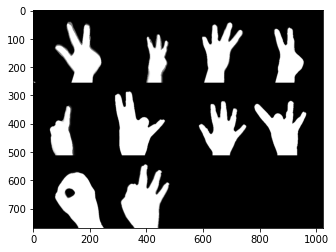

In [7]:
def get_image_shape():
    img = cv.imread('drive/My Drive/Colab Notebooks/ITSP/mydata/1/1.jpg', 0)
    return img.shape


img_shape = get_image_shape()
print('Image shape: ', img_shape)
root = 'drive/My Drive/Colab Notebooks/ITSP/mydata'
gesture_data = os.listdir(root)
num_g = len(gesture_data)
print('Number of gestures: ', num_g)
num_rows = int(num_g/4)

if(num_g%4):
   num_rows+=1

print('Number of rows: ', num_rows)

begin = 0
final_img = None

for i in range(num_rows):
    row_img = None
    for j in range(begin, begin+4):
        if (j>= num_g):
            img = np.zeros(img_shape, dtype = np.uint8)
            #print('Image index: ', j, 'false')
            
        else:         
            imgpath = root + '/' + reverselookup[j] + '/' + str(random.randint(1, 200)) + '.jpg'
            img = cv.imread(imgpath, 0)
            #if not np.any(img == None):
                #print('Image index: ', j, 'true')
            
        if np.any(row_img == None):
            row_img = img
        else:
            row_img = np.hstack((row_img, img))
            
    begin += 4
    if np.any(final_img == None):
            final_img = row_img
    else:
        final_img = np.vstack((final_img, row_img))  
                        
plt.imshow(final_img, cmap='gray')
#cv.waitKey(0)
#cv.destroyAllWindows()        

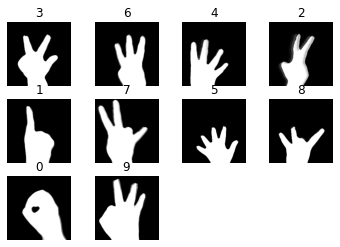

In [8]:
gestures = []
titles = []

for i in range(num_g):
    imgpath = root + '/' + reverselookup[i] + '/' + str(random.randint(1, 200)) + '.jpg'
    img = cv.imread(imgpath, 0)
    gestures.append(img)
    titles.append(reverselookup[i])
    
for i in range(num_g):
    plt.subplot(3, 4, i+1)
    plt.imshow(gestures[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

In [9]:
from torchvision import models
model = models.resnet101(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

In [10]:
torch.save(model, 'drive/My Drive/Colab Notebooks/ITSP/weights2.pth')
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
n_classes = 10

model.fc = nn.Sequential(
                      nn.Linear(2048, 512), 
                      nn.ReLU(), 
                      nn.Linear(512, 256), 
                      nn.ReLU(),
                      nn.Dropout(0.2), 
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
total_params = sum(p.numel() for p in model.parameters())

print(f'{total_params:,} total parameters')

total_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'{total_trainable:,} trainable parameters.')

43,683,146 total parameters
1,182,986 trainable parameters.


In [13]:
# Move to gpu
model = model.to('cuda')
# Distribute across 2 gpus
model = nn.DataParallel(model)

loss_func = F.cross_entropy
optimizer = optim.Adam(model.parameters(), betas=(0.5, 0.99), lr = 0.002)


In [14]:
def accuracy(out, yb):
    pred = torch.argmax(out, keepdim= False, dim=1)
    return (pred == yb).float().mean() 

In [15]:
def fit(model, epochs, train_loader, valid_loader, opt):
    losses = []
    
    for epoch in range(epochs):
        train_loss =0
        train_acc =0
        model.train()
        for xb, yb in train_loader:
            xb =xb.to(device)
            yb = yb.to(device)
            pred = model(xb.float())
            pred.to(device)
            train_acc += accuracy(pred, yb)
            loss = loss_func(pred, yb)
            train_loss += loss
            #back propogation
            loss.backward()
            opt.step()
            opt.zero_grad()      

        losses.append(train_loss)
        print("Iteration no: "+ str(epoch), "loss = "+str(losses[epoch].item()))
        print("Accuracy of train set:", train_acc/len(train_loader))
        lr_scheduler.step(train_loss/len(train_loader))
        
        
        model.eval()    
        with torch.no_grad():
            valid_acc=0
            loss_valid = 0
            for xb_valid, yb_valid in valid_loader:
                xb_valid = xb_valid.to(device)
                yb_valid = yb_valid.to(device)
                pred_valid = model(xb_valid.float())
                pred_valid.to(device)
                valid_acc += accuracy(pred_valid, yb_valid)
                loss_valid += loss_func(pred_valid, yb_valid)
            print("Accuracy of validation set :", valid_acc/len(valid_loader))
            #callbacks = [EarlyStopping(monitor='valid_acc', verbose=False, mode='max', patience=10)]

    plt.plot(losses)
    plt.ylabel("loss")
    plt.xlabel("iterations")
    plt.show()

In [16]:
#model.set_callbacks(callbacks)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=True, eps = 10e-14)

Iteration no: 0 loss = 287.7423400878906
Accuracy of train set: tensor(0.4883, device='cuda:0')
Accuracy of validation set : tensor(0.7955, device='cuda:0')
Iteration no: 1 loss = 168.6874237060547
Accuracy of train set: tensor(0.6994, device='cuda:0')
Accuracy of validation set : tensor(0.7955, device='cuda:0')
Iteration no: 2 loss = 143.35958862304688
Accuracy of train set: tensor(0.7502, device='cuda:0')
Accuracy of validation set : tensor(0.8295, device='cuda:0')
Iteration no: 3 loss = 132.69439697265625
Accuracy of train set: tensor(0.7720, device='cuda:0')
Accuracy of validation set : tensor(0.7500, device='cuda:0')
Iteration no: 4 loss = 120.90390014648438
Accuracy of train set: tensor(0.8038, device='cuda:0')
Accuracy of validation set : tensor(0.8523, device='cuda:0')
Iteration no: 5 loss = 116.82665252685547
Accuracy of train set: tensor(0.8068, device='cuda:0')
Accuracy of validation set : tensor(0.8409, device='cuda:0')
Iteration no: 6 loss = 108.10679626464844
Accuracy of 

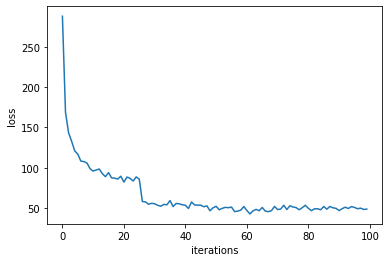

In [17]:
fit(model, 100, train_loader, valid_loader, optimizer)

In [18]:
torch.save(model, 'drive/My Drive/Colab Notebooks/ITSP/gest_full10.pth')